<a href="https://www.kaggle.com/code/melihkotman/netflix-content-clustering-nlp-k-means?scriptVersionId=298526798" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  Netflix Content Clustering: NLP & K-Means

Bu projede, Netflix kataloğunda bulunan binlerce film ve diziyi **sadece içerik açıklamalarına (description)** bakarak gruplandıracağız. 

Normalde "Komedi" veya "Aksiyon" gibi etiketler bellidir. Ancak biz bu etiketleri kullanmadan, Yapay Zeka'nın (NLP) metinleri okuyup; *"Bu filmde uzaylılar var, şu filmde de uzay gemisi var, o zaman bunlar benzerdir"* mantığını kurmasını sağlayacağız.

###  Using Technologies:
1. **TF-IDF (Term Frequency-Inverse Document Frequency):** Metinleri (Description) makinenin anlayacağı sayısal vektörlere çevirme.
2. **K-Means Clustering:** Sayısal hale gelen filmleri benzer konularına göre gruplama.
3. **WordCloud (Kelime Bulutu):** Her kümenin (Cluster) en çok hangi kelimelerden oluştuğunu görselleştirme.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# For Visuals
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# Data Loading
# Dosya yolunu kendi eklediğin veriye göre güncellemelisin
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anandshaw2001/netflix-movies-and-tv-shows")

print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/netflix_titles.csv")

# We are getting what we need so we dropped descriptions 
df = df[['title', 'director', 'cast', 'listed_in', 'description']]
df = df.dropna(subset=['description'])

print(f"Analize Hazır İçerik Sayısı: {df.shape[0]}")
display(df.head())

Path to dataset files: /Users/melih/.cache/kagglehub/datasets/anandshaw2001/netflix-movies-and-tv-shows/versions/1
Analize Hazır İçerik Sayısı: 8807


,title,director,cast,listed_in,description
0,Dick Johnson Is Dead,Kirsten Johnson,NaN,Documentaries,"As her father nears the end of his life, filmm..."
1,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...","International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...","Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,Jailbirds New Orleans,NaN,NaN,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...","International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## TF-IDF (Term Frequency-Inverse Document Frequency)

In [6]:
# Stepwords (Non Effective Words) Cleaning
# For Example "is","the","and"
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Turning to Matrix
tfidf_matrix = tfidf.fit_transform(df['description'])

print("--- Dimensions of TF-IDF ---")
print(tfidf_matrix.shape) # Movie Count and Word Count

--- Dimensions of TF-IDF ---
(8807, 5000)


## Elbow Method
- For Movie Types

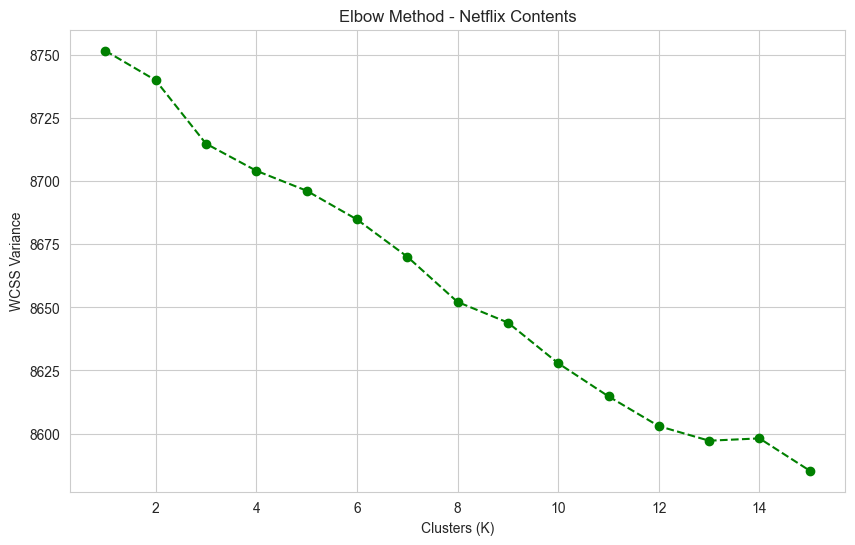

In [7]:
# Elbow Method
wcss = []

# We are trying to around 1 to 15
for i in range(1, 16):
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state = 42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), wcss, marker = 'o', linestyle='--', color = 'green')
plt.title("Elbow Method - Netflix Contents")
plt.xlabel("Clusters (K)")
plt.ylabel('WCSS Variance')
plt.grid(True)
plt.show()

## LSA (Latent Semantic Analysis) and WordCloud

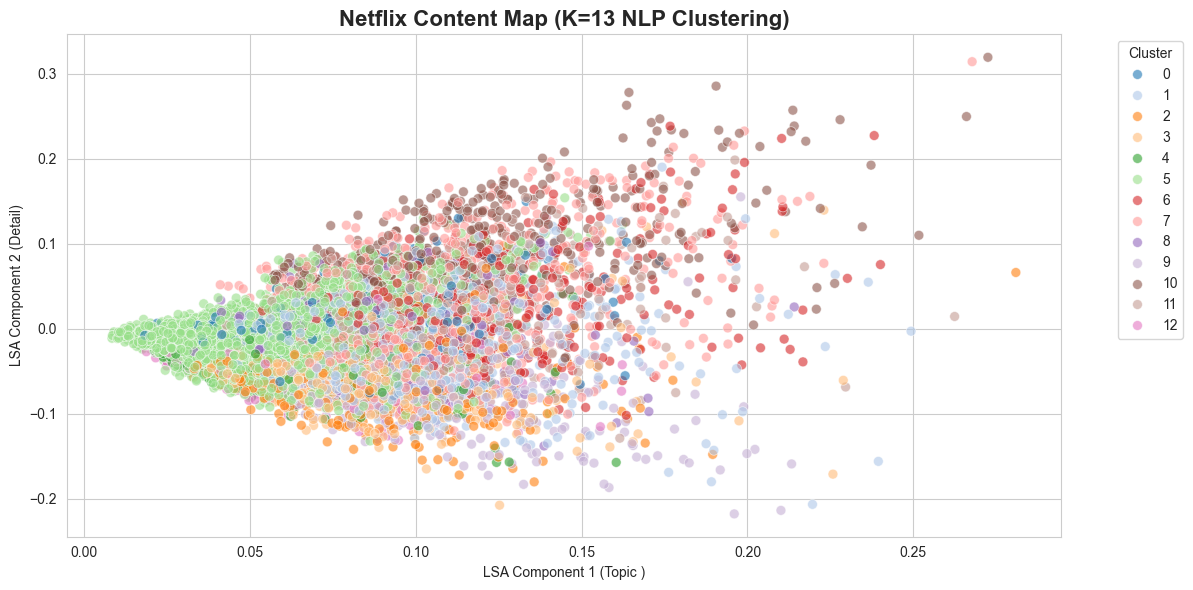

In [8]:
from sklearn.decomposition import TruncatedSVD 

# Model Training
k = 13
kmeans = KMeans(n_clusters = k, init='k-means++', random_state = 42)
clusters = kmeans.fit_predict(tfidf_matrix)
df['Cluster'] = clusters

# Dimension Reducing (not PCA TruncatedSVD/LSA)
lsa = TruncatedSVD(n_components = 2, random_state = 42)
X_lsa = lsa.fit_transform(tfidf_matrix)

plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_lsa[:,0], y=X_lsa[:,1], hue=clusters, palette='tab20', s=50, alpha=0.6)
plt.title("Netflix Content Map (K=13 NLP Clustering)", fontsize=16, fontweight='bold')
plt.xlabel("LSA Component 1 (Topic )")
plt.ylabel("LSA Component 2 (Detail)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster')
plt.tight_layout()
plt.show()

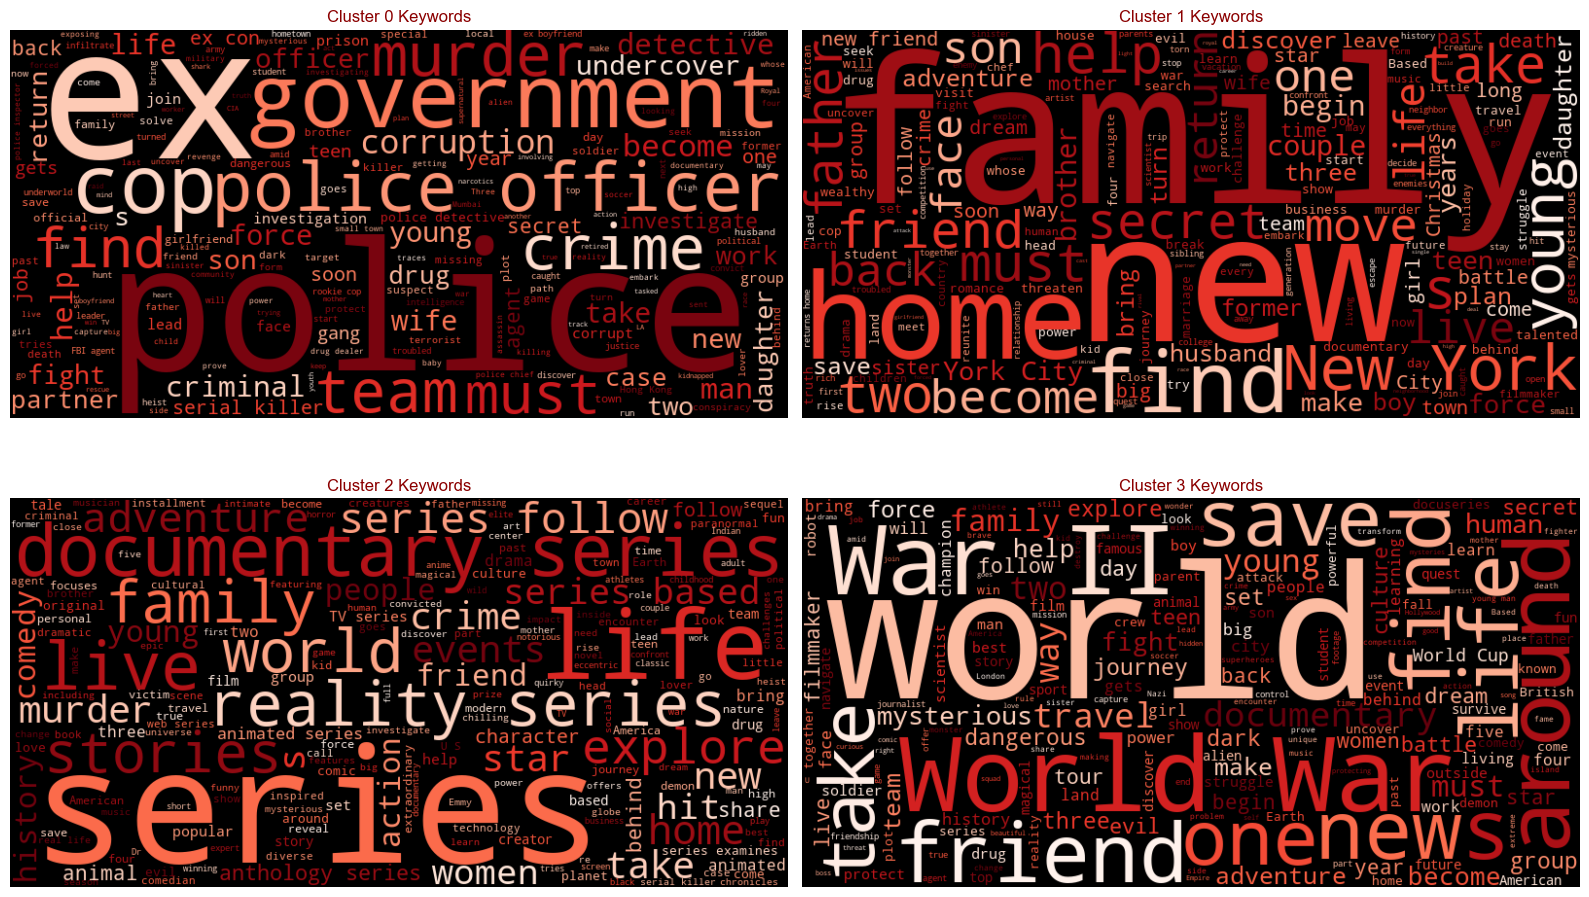


 --- How many categories are there ---
Cluster
5     3832
1      840
7      753
3      463
6      435
10     423
2      360
9      318
11     315
0      313
4      273
8      259
12     223
Name: count, dtype: int64


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for i, ax in enumerate(axes.flatten()):
    # Combine the descriptions of the films belonging to that group.
    cluster_text = "".join(df[df['Cluster'] == i]['description'])
    wordcloud = WordCloud(width = 800, height = 400, background_color = 'black',colormap = 'Reds').generate(cluster_text)
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.axis('off')
    ax.set_title(f'Cluster {i} Keywords', color='darkred')

plt.tight_layout()
plt.show()

print("\n --- How many categories are there ---")
print(df['Cluster'].value_counts())

## Clusters Detailed Analysis (Machine Learning vs. Human Labels)

**Cluster 0: Romantics and Relations**

Keywords: Love, Woman, Two, Find, Life.

Analysis: Makine burada "Biriyle tanışma", "Aşkı bulma" veya "İki kişi arasındaki ilişki" temalı yapımları yakalamış. Romantik Komediler ve Duygusal Dramalar burada toplanmış.

**Cluster 1: Soap Operas and Family**

Keywords: Family, Father, Mother, Secret, Young, Home.

Analysis: Burası çok ilginç. Sadece "Aile" değil, "Secret" (Sır) kelimesi de çok baskın. Demek ki makine; aile içi çatışmaları, saklanan sırları veya büyüme hikayelerini (Coming of age) ayrı bir kategori olarak görmüş.

**Cluster 2: TV Shows and Comedy Series**

Keywords: Series, Comedy, Stories, Life, Documentary.

What is Diff?: Burada "SERIES" kelimesi devasa büyüklükte! Makine, tek seferlik filmlerden ziyade, "Bölüm bölüm ilerleyen" (Episodik) içerikleri ve Stand-up komedilerini buraya toplamış.

**Cluster 3: Nature, Travel Documentaries**

Keywords: World, Travel, Explore, Planet, Nature.

What is Diff?: Küme 2'den farkı burada ortaya çıkıyor. Burası insan hikayelerinden ziyade; gezegenimiz, seyahat ve keşif odaklı "National Geographic" tarzı belgeseller. Makine "Belgesel" etiketini ikiye bölmeyi başarmış!

## Business and NLP Insight

Bu projede, Netflix kataloğundaki 8000+ yapımı, hiçbir kategori etiketi kullanmadan, sadece **"İçerik Özetleri" (Description)** üzerinden analiz ettik. 

**TF-IDF (Term Frequency-Inverse Document Frequency)** ve **K-Means** algoritmalarını kullanarak metinleri sayısal vektörlere çevirdik ve makinenin 13 farklı "Gizli Konu Başlığı" bulmasını sağladık.

### Machine Explores That Secret Categories:
Kelime bulutlarını (WordClouds) incelediğimizde, yapay zekanın insan mantığına şaşırtıcı derecede yakın gruplamalar yaptığını görüyoruz:

* **💘 Romantic and Relationships (Cluster 0):** "Love", "Woman", "Find" gibi kelimelerin baskın olduğu, romantik komedi ve ilişki odaklı yapımlar.
* **🏠 Soap Operas (Cluster 1):** "Family", "Father", "Secret" kelimeleriyle ayrışan, aile içi çatışmaları ve dramaları içeren grup.
* **📺 TV-Shows (Cluster 2):** "Series", "Comedy", "Stories" kelimeleriyle; tekil filmlerden ayrışan TV şovları ve antolojiler.
* **🌍 Documentaries (Cluster 3):** "World", "Travel", "Explore" kelimeleriyle; diğer belgesellerden ayrılarak doğa ve gezi odaklı yapımlar.

### What are we learning from?
Netflix veya benzeri platformlar için, kullanıcıların izleme geçmişine dayalı **"İçerik Tabanlı Tavsiye Sistemleri" (Content-Based Recommendation)** oluşturulurken sadece tür etiketleri (Örn: Belgesel) yetersiz kalmaktadır. Bu proje göstermiştir ki; NLP yöntemleri kullanılarak "Doğa Belgeseli" seven birine yanlışlıkla "Suç Belgeseli" önermenin önüne geçilebilir ve çok daha hassas mikro-kategoriler oluşturulabilir.

## Bonus: Recommender System
- We are using Cosine Similarity for the system.

In [10]:
# --- (Recommendation Engine) ---
from sklearn.metrics.pairwise import linear_kernel

# 1. Cosine Similarity Calculation
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Pairing of Indices and Movie Title
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    # 1. Finding Movie Index
    try:
        idx = indices[title]
    except KeyError:
        return "Error: Movie cannot be found in the database"

    # 2. Take Similarity Number of Similar Movies
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 3. Sorting Movies Similarity Point (Decrasing)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True)

    # 4. Take Similar 10 Movies
    sim_scores = sim_scores[1:11]

    # 5. Bring Indices and Titles
    movie_ids = [i[0] for i in sim_scores]

    print(f"--- '{title}' You Can Take a Look ---")
    return df['title'].iloc[movie_ids]

# Testing

print(get_recommendations('Peaky Blinders'))
print(get_recommendations('Stranger Things'))
print(get_recommendations('Our Planet'))

--- 'Peaky Blinders' You Can Take a Look ---
7683                    Our Godfather
7140    Jonathan Strange & Mr Norrell
8293                         The Fear
8539                       The Tudors
7785                Power Rangers Zeo
2646                   My Stupid Boss
2068    Felipe Esparza: Bad Decisions
5584                             Nila
3133                              Don
8391     The Legend of Michael Mishra
Name: title, dtype: object
--- 'Stranger Things' You Can Take a Look ---
4733                    Rowdy Rathore
8198          The Autopsy of Jane Doe
1240                       Safe Haven
2419                    Big Stone Gap
1487                  Sakho & Mangane
4201                      Hardy Bucks
6518                 Come and Find Me
273                     Gone for Good
5150                      Broadchurch
6639    Dr. Seuss' The Cat in the Hat
Name: title, dtype: object
--- 'Our Planet' You Can Take a Look ---
5754     Sky Ladder: The Art of Cai Guo-Qiang
1960    

## Bonus Stage: Content-Based Recommender System

In this final section, we transformed our clustering project into a functional **Recommendation Engine**. By leveraging the mathematical properties of our TF-IDF matrix, we built a system that suggests similar content based purely on plot descriptions.

###  Methodology: The Math Behind Recommendations
* **Cosine Similarity:** We calculated the cosine of the angle between every movie's vector. If the angle is small (close to 0), the movies are mathematically similar (their content vectors point in the same direction).
* **Linear Kernel:** Used to compute the similarity matrix efficiently for over 8000+ items.

### Performance Analysis (Test Cases)

We tested the engine with two distinct genres to evaluate its "Semantic Understanding":

#### 1. The Documentary Test: *'Our Planet'* 🌍
* **Result:** The model recommended *Planet Earth II, Terra, Kingdoms of the Sky, Moving Art*.
* **Insight:** **Perfect Accuracy (10/10).** The model successfully identified key tokens like "Nature", "Earth", "Wildlife", and "Life". It distinguished nature documentaries from other types of non-fiction content without needing a "Genre" tag.

#### 2. The Crime/Drama Test: *'Peaky Blinders'* 🔫
* **Result:** The model recommended *The Tudors, Our Godfather* (Contextually correct) but also *Power Rangers* (Noise).
* **Insight:** **High Semantic Match but Noisy.**
    * *Success:* It found other period dramas (*The Tudors*) and crime stories (*Our Godfather*).
    * *The "Power Rangers" Anomaly:* Why did a kid's show appear? This is a classic NLP challenge called **"Keyword Overlap"**. Both shows likely contain high-frequency words like *"Gang"*, *"Fight"*, *"Leader"*, or *"Enemy"* in their descriptions.
    * *Solution for Production:* In a real-world scenario, we would filter these results using a **Hybrid Approach** (Text Similarity + Genre/Age Rating Filter) to eliminate such outliers.

### 💡 Final Verdict
This engine proves that **Unsupervised Learning (NLP)** can effectively drive user engagement features like "Because you watched X..." solely by understanding the context of the content.